# Predicting Business Popularity
##### Pytorch Geometric implementation with NetworkX graph

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 2.6MB 44.2MB/s 
     |████████████████████████████████| 1.5MB 16.9MB/s 
     |████████████████████████████████| 1.0MB 516kB/s 
     |████████████████████████████████| 215kB 26.2MB/s 
     |████████████████████████████████| 235kB 44.0MB/s 
     |████████████████████████████████| 2.2MB 50.8MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as pyg_nn
import torch_geometric.transforms as pyg_transforms
import torch_cluster

import networkx as nx
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating the network graph datasets

We use NetworkX to read and parse the graph into train/validate/test sets. We load these into DataLoader to use mini-batching.

In [ ]:
G = nx.read_gpickle("./drive/MyDrive/Colab Notebooks/restaurant_graph/restaurants_user_influence.gpickle")

In [ ]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 29963
Number of edges: 491371


In [ ]:
H = Graph(G)
dataset = GraphDataset(graphs=[H], task='node')

In [ ]:
print(dataset.graphs[0])

Graph(G=[], edge_index=[2, 982742], edge_label_index=[2, 982742], node_feature=[29963, 539], node_label=[29963], node_label_index=[29963], node_type=[29963], task=[])


In [ ]:
dataset.graphs[0].node_label = torch.LongTensor(dataset.graphs[0].node_label)
print(dataset.graphs[0].node_label)
print(dataset.graphs[0].node_label_index)

tensor([2, 2, 1,  ..., 2, 2, 1])
tensor([    0,     1,     2,  ..., 29960, 29961, 29962])


In [ ]:
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1], shuffle=True)

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=16)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=16)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=16)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels
print(f"There are {num_node_features} features and {num_classes} labels.")

There are 539 features and 3 labels.


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the popularity category, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_node_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=539, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
x = dataset.graphs[0].node_feature
y = dataset.graphs[0].node_label

print(x.size())
print(y.size())

torch.Size([29963, 539])
torch.Size([29963])


In [ ]:
import numpy as np

mask = np.random.rand(1, y.size()[0])

train_mask = (mask < 0.9)[0]
test_mask = (mask >= 0.9)[0]

print(train_mask)
print(test_mask)

[ True  True  True ... False  True  True]
[False False False ...  True False False]


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(x)  # Perform a single forward pass.
      loss = criterion(out[train_mask], y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 500):
    loss = train()
    if epoch % 5 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 005, Loss: 0.9924
Epoch: 010, Loss: 0.9098
Epoch: 015, Loss: 0.8467
Epoch: 020, Loss: 0.8072
Epoch: 025, Loss: 0.7907
Epoch: 030, Loss: 0.7714
Epoch: 035, Loss: 0.7664
Epoch: 040, Loss: 0.7591
Epoch: 045, Loss: 0.7504
Epoch: 050, Loss: 0.7438
Epoch: 055, Loss: 0.7387
Epoch: 060, Loss: 0.7367
Epoch: 065, Loss: 0.7362
Epoch: 070, Loss: 0.7339
Epoch: 075, Loss: 0.7269
Epoch: 080, Loss: 0.7290
Epoch: 085, Loss: 0.7233
Epoch: 090, Loss: 0.7252
Epoch: 095, Loss: 0.7231
Epoch: 100, Loss: 0.7195
Epoch: 105, Loss: 0.7193
Epoch: 110, Loss: 0.7170
Epoch: 115, Loss: 0.7164
Epoch: 120, Loss: 0.7158
Epoch: 125, Loss: 0.7139
Epoch: 130, Loss: 0.7143
Epoch: 135, Loss: 0.7136
Epoch: 140, Loss: 0.7111
Epoch: 145, Loss: 0.7122
Epoch: 150, Loss: 0.7122
Epoch: 155, Loss: 0.7141
Epoch: 160, Loss: 0.7124
Epoch: 165, Loss: 0.7120
Epoch: 170, Loss: 0.7086
Epoch: 175, Loss: 0.7130
Epoch: 180, Loss: 0.7081
Epoch: 185, Loss: 0.7082
Epoch: 190, Loss: 0.7052
Epoch: 195, Loss: 0.7062
Epoch: 200, Loss: 0.7046


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6932


## Logistic Regression

In [ ]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.2, random_state = 1)

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lm.score(X_test, y_test)

0.6686133822793259

## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        conv_model = self.build_conv_model(args["model"])
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_size, hidden_size, aggr="max"))

        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_size, hidden_size, aggr="max"))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, node_label_index, batch = data.node_feature, data.edge_index, data.node_label_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GAT':
            return pyg_nn.GATConv
        elif model_type == "GraphSage":
            return pyg_nn.SAGEConv
        elif model_type == "TransformerConv":
            return pyg_nn.TransformerConv
        else:
            raise ValueError(
                "Model {} unavailable, please add it to GNN.build_conv_model.".format(model_type))

In [ ]:
def train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    losses = []
    accuracies = [[], [], []] # train / validate / test

    for epoch in range(1, args['epochs']+1):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = test_gnn(train_loader, model, device)
        val_acc = test_gnn(val_loader, model, device)
        test_acc = test_gnn(test_loader, model, device)

        if epoch % 5 == 0:
          print(f"Epoch {epoch}: Train: {train_acc:.4f}, Validation: {val_acc:.4f}. Test: {test_acc:.4f}, Loss: {total_loss:.4f}")

        losses.append(round(total_loss, 4))
        accuracies[0].append(train_acc)
        accuracies[1].append(val_acc)
        accuracies[2].append(test_acc)

    return (model, losses, accuracies)

def test_gnn(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 250})'''))

args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 64,
    "epochs" : 250,
    "lr" : 0.01,
    "num_layers": 2,
    "model": "GraphSage" # [GraphSage, GAT, GCN, TransformerConv]
}

gnn_model, losses, accuracies = train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])

<IPython.core.display.Javascript object>

GNN(
  (convs): ModuleList(
    (0): SAGEConv(539, 64)
    (1): SAGEConv(64, 64)
  )
  (post_mp): Linear(in_features=64, out_features=3, bias=True)
)
Epoch 5: Train: 0.4417, Validation: 0.4476. Test: 0.4438, Loss: 4.2463
Epoch 10: Train: 0.4751, Validation: 0.4656. Test: 0.4808, Loss: 1.7976
Epoch 15: Train: 0.4888, Validation: 0.4927. Test: 0.5032, Loss: 1.6576
Epoch 20: Train: 0.5196, Validation: 0.5130. Test: 0.5249, Loss: 1.2882
Epoch 25: Train: 0.4983, Validation: 0.4910. Test: 0.5045, Loss: 1.2357
Epoch 30: Train: 0.4864, Validation: 0.4710. Test: 0.4795, Loss: 1.0936
Epoch 35: Train: 0.5007, Validation: 0.5010. Test: 0.5038, Loss: 1.0322
Epoch 40: Train: 0.5428, Validation: 0.5257. Test: 0.5422, Loss: 0.9925
Epoch 45: Train: 0.5602, Validation: 0.5454. Test: 0.5569, Loss: 0.9785
Epoch 50: Train: 0.5700, Validation: 0.5631. Test: 0.5716, Loss: 0.9579
Epoch 55: Train: 0.6018, Validation: 0.5948. Test: 0.5996, Loss: 0.9291
Epoch 60: Train: 0.6117, Validation: 0.6088. Test: 0.6210, 

### Plotting training data 

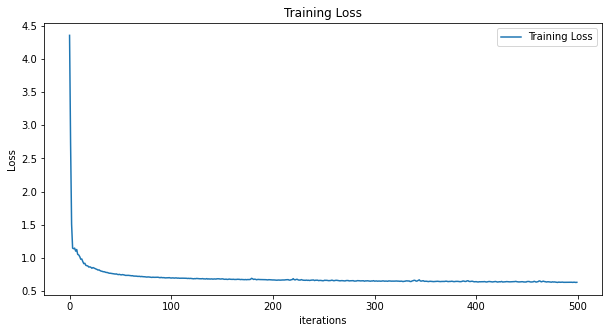

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses, label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

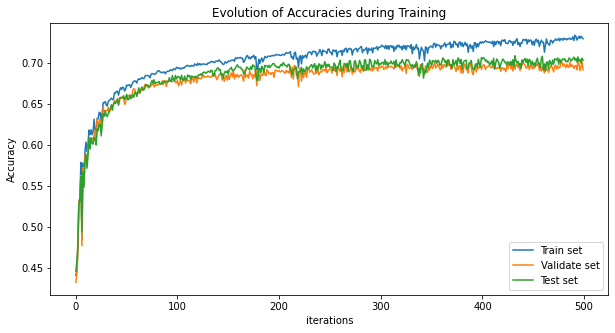

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Evolution of Accuracies during Training")
plt.plot(accuracies[0],label="Train set")
plt.plot(accuracies[1],label="Validate set")
plt.plot(accuracies[2],label="Test set")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Report

In [ ]:
final_test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=len(dataset_test))

y_pred = None
y_true = None

gnn_model.eval()
for batch in final_test_loader:
    batch.to("cuda")
    logits = gnn_model(batch)
    y_pred = logits[batch.node_label_index].max(1)[1]
    y_true = batch.node_label

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Low', 'Middle', 'High']
print(classification_report(y_true.cpu(), y_pred.cpu(), target_names=target_names))

              precision    recall  f1-score   support

         Low       0.68      0.78      0.73       973
      Middle       0.56      0.45      0.50      1008
        High       0.77      0.80      0.78      1016

    accuracy                           0.68      2997
   macro avg       0.67      0.68      0.67      2997
weighted avg       0.67      0.68      0.67      2997

